<a href="https://colab.research.google.com/github/jafetsierra/SVHN-classifier/blob/main/SVHN_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVHN  dataset Classifier  

-esp-
Clasificador para la base de datos del SVHN con numeros tomados de google maps de direcciones reales. 



-eng-
MPL and CNN neural networks for the SVHN dataset (set of google maps photos from real houses directions)






In [3]:
#import all the libraries need it
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

I work with two files: `train_32x32.mat` and `test_32x32.mat`.

The main goal is to build, train and evaluate a neural network able to classifies a real-word images into one of ten diferent classes


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Load the dataset from your Drive folder

train = loadmat('/content/drive/MyDrive/Introduction_tensorflow_week_5_assignment/train_32x32.mat')
test = loadmat('/content/drive/MyDrive/Introduction_tensorflow_week_5_assignment/test_32x32.mat')


#Train and Test are dictionaries with 'X' and 'y' as the keys for the data_input and labels respectively. 


# Preprocessing the dataset

The train images are in the format of rgb images, with a shape of (32,32,3). The first step was converted that into a single channel (grayscale) and divided the values by 255 in order to normalize the data. 



In [1]:
#Extracting the training and the test images and labels
train_data = train['X']/255
si = lambda x : 0 if x==10 else (x)
train_labels = [si(x[:][0]) for x in train['y']]
train_labels = np.array(train_labels)
test_data = test['X']/255
test_labels = [si(y[0]) for y in test['y']]
test_labels = np.array(test_labels)

#With this the format of the label change, from a single number to a categorical list with a lenght of 10.
train_targets = tf.keras.utils.to_categorical(train_labels)
test_targets = tf.keras.utils.to_categorical(test_labels)

NameError: ignored

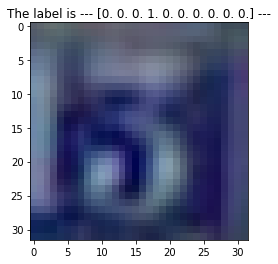

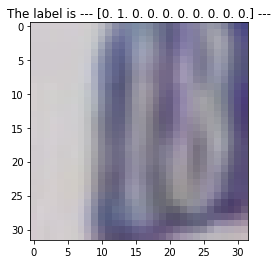

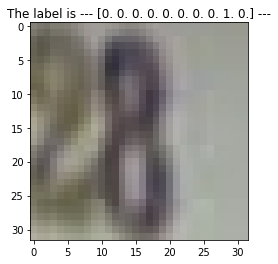

In [7]:
#Selecting a random images and labels and printing them 
random = np.random.randint(0,1000,3)
for i in random:
  plt.imshow(train_data[:,:,:,i])
  plt.title('The label is --- {} ---'.format(train_targets[i]))
  plt.show()

In [8]:
#grayscaling train and test data. 
gray_train = []
for i in range(train_data.shape[3]):
  a = (train_data[:,:,0,i]+train_data[:,:,1,i]+train_data[:,:,2,i])/3
  gray_train.append(a)
train_data_gray = np.asarray(gray_train)

gray_test = []
for i in range(test_data.shape[3]):
  a = (test_data[:,:,0,i]+test_data[:,:,1,i]+test_data[:,:,2,i])/3
  gray_test.append(a)
test_data_gray = np.asarray(gray_test)
test_data_gray.shape

(26032, 32, 32)

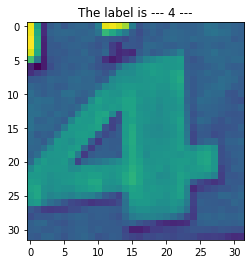

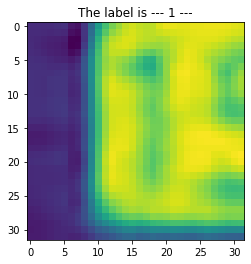

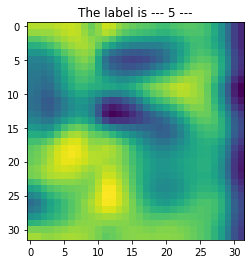

In [9]:
random_2 = np.random.randint(0,1000,3)
for i in random_2:
  plt.imshow(train_data_gray[i,:,:])
  plt.title('The label is --- {} ---'.format(train_labels[i]))
  plt.show()

## MLP neural network classifier


In [8]:
#model with 5 dense layers, L2 regularization, dropout and Adam optimizer
def get_mpl_model(wd,t_d,d_r):
  model = Sequential([
                      Dense(512, kernel_regularizer=regularizers.L2(wd),kernel_initializer='he_normal', bias_initializer='ones',input_shape=t_d),
                      Dropout(d_r),
                      Dense(256, kernel_regularizer=regularizers.L2(wd),activation='relu'),
                      Dropout(d_r),
                      Dense(128, kernel_regularizer=regularizers.L2(wd),activation='relu'),
                      Dropout(d_r),
                      Dense(64, kernel_regularizer=regularizers.L2(wd),activation='relu'),
                      Dropout(d_r),
                      Flatten(),
                      Dense(10, activation='softmax')
  ])
  opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
  model.compile(
      optimizer=opt,
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  
  return model

In [9]:
model = get_mpl_model(0.5e-5,train_data_gray[0].shape,0.30)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32, 512)           16896     
_________________________________________________________________
dropout (Dropout)            (None, 32, 512)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 32, 256)           131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 256)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 32, 128)           32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 128)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 32, 64)            8

In [17]:
#Callbacks
def scheduler(epoch,lr):
  if epoch<10:
    return lr 
  else:
    return lr*tf.math.exp(-0.05)

def checkpoint_best():
  path = 'checkpoint_best/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp

def checkpoint_best_cnn():
  path = 'checkpoint_best_cnn/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp
def train_model(model, train_data, train_labels, epochs):
  callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler),checkpoint_best()]
  return model.fit(train_data, train_labels,epochs=epochs, 
      batch_size=16, validation_split=0.15,
      callbacks=callbacks,
      verbose=1)
def train_cnn_model(model, train_data, train_labels, epochs):
  callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler),checkpoint_best_cnn()]
  return model.fit(x=train_data, y=train_labels,epochs=epochs, 
      batch_size=32, validation_split=0.15,
      callbacks=callbacks,
      verbose=1)

In [ ]:
history = train_model(model, train_data_gray, train_targets, 30)

Epoch 1/30
3892/3892 [==============================] - 20s 5ms/step - loss: 2.2573 - accuracy: 0.1839 - val_loss: 2.1660 - val_accuracy: 0.2213

Epoch 00001: val_accuracy improved from -inf to 0.22131, saving model to checkpoint_best/checkpoint
Epoch 2/30
3892/3892 [==============================] - 19s 5ms/step - loss: 2.0353 - accuracy: 0.2920 - val_loss: 1.7865 - val_accuracy: 0.4251

Epoch 00002: val_accuracy improved from 0.22131 to 0.42506, saving model to checkpoint_best/checkpoint
Epoch 3/30
3892/3892 [==============================] - 19s 5ms/step - loss: 1.6371 - accuracy: 0.4771 - val_loss: 1.3708 - val_accuracy: 0.5740

Epoch 00003: val_accuracy improved from 0.42506 to 0.57403, saving model to checkpoint_best/checkpoint
Epoch 4/30
3892/3892 [==============================] - 19s 5ms/step - loss: 1.4042 - accuracy: 0.5628 - val_loss: 1.2179 - val_accuracy: 0.6256

Epoch 00004: val_accuracy improved from 0.57403 to 0.62563, saving model to checkpoint_best/checkpoint
Epoch 5

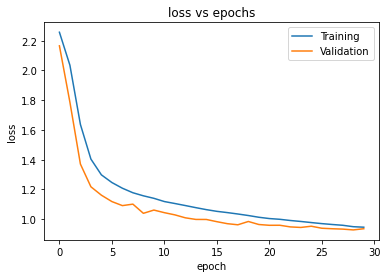

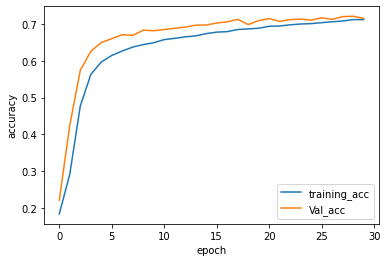

In [ ]:
#plotting the loss for training and validation set
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss vs epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
#plotting the accuracy for both, training and validation set. 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training_acc','Val_acc'])
plt.show()

In [36]:
def get_test_accuracy(model, x_test, y_test):
  test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
  print('accuracy: {acc:0.3f}'.format(acc=test_acc))
  print('loss: {loss:0.3f}'.format(loss=test_loss))

In [ ]:
get_test_accuracy(model, test_data_gray, test_targets)

accuracy: 0.713
loss: 0.968


In [ ]:
model.load_weights('/content/drive/MyDrive/Introduction_tensorflow_week_5_assignment/checkpoint_best/checkpoint')
get_test_accuracy(model, test_data_gray, test_targets)

accuracy: 0.712


## CNN neural network classifier


In [31]:

#CNN classifer 
def get_cnn_model(td_shape,w_d,d_r):
  model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', padding='same',input_shape=td_shape,
           kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    MaxPooling2D((2,2)),
    Dropout(d_r),
    Conv2D(16, kernel_size=(2,2),activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(d_r),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(w_d)),
    Dropout(d_r),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(w_d)),
    Dropout(d_r),
    Dense(10, activation='softmax')
  ])
  opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
  model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [32]:
train_data_gray_cnn = np.reshape(train_data_gray,(73257,32,32,1))
test_data_gray_cnn = np.reshape(test_data_gray,(26032,32,32,1))
cnn_model = get_cnn_model(train_data_gray_cnn[0].shape, 1e-5, 0.20)
cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 16)        2064      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)             

In [33]:
history_cnn = train_cnn_model(cnn_model,train_data_gray_cnn,train_targets,30)

Epoch 1/30
1946/1946 [==============================] - 15s 7ms/step - loss: 1.7931 - accuracy: 0.3724 - val_loss: 0.9471 - val_accuracy: 0.7350

Epoch 00001: val_accuracy improved from -inf to 0.73501, saving model to checkpoint_best_cnn/checkpoint
Epoch 2/30
1946/1946 [==============================] - 13s 7ms/step - loss: 0.9200 - accuracy: 0.7116 - val_loss: 0.6359 - val_accuracy: 0.8121

Epoch 00002: val_accuracy improved from 0.73501 to 0.81208, saving model to checkpoint_best_cnn/checkpoint
Epoch 3/30
1946/1946 [==============================] - 14s 7ms/step - loss: 0.7522 - accuracy: 0.7670 - val_loss: 0.5489 - val_accuracy: 0.8369

Epoch 00003: val_accuracy improved from 0.81208 to 0.83693, saving model to checkpoint_best_cnn/checkpoint
Epoch 4/30
1946/1946 [==============================] - 13s 7ms/step - loss: 0.6814 - accuracy: 0.7896 - val_loss: 0.5063 - val_accuracy: 0.8563

Epoch 00004: val_accuracy improved from 0.83693 to 0.85631, saving model to checkpoint_best_cnn/ch

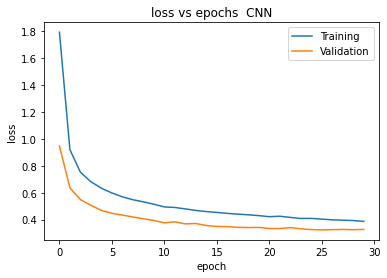

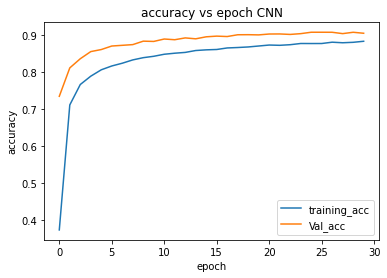

In [34]:
#plotting the loss for training and validation set
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('loss vs epochs  CNN')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
#plotting the accuracy for both, training and validation set. 
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('accuracy vs epoch CNN')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training_acc','Val_acc'])
plt.show()

In [37]:
get_test_accuracy(cnn_model, test_data_gray_cnn,test_targets)

accuracy: 0.901
loss: 0.351



## Get model predictions


In [15]:
#MPL model
model = get_mpl_model(1e-5,train_data_gray[0].shape,0.30)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32, 512)           16896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 512)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 32, 256)           131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 256)           0         
_________________________________________________________________
dense_10 (Dense)             (None, 32, 128)           32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 128)           0         
_________________________________________________________________
dense_11 (Dense)             (None, 32, 64)           

In [16]:
model.load_weights('/content/drive/MyDrive/Introduction_tensorflow_week_5_assignment/checkpoint_best/checkpoint')
get_test_accuracy(model, test_data_gray, test_targets)

accuracy: 0.719
loss: 0.970


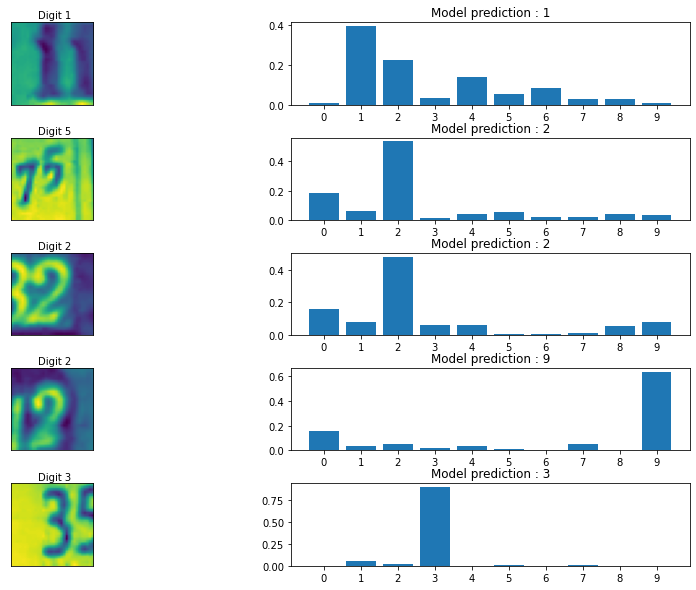

In [19]:
index_random = np.random.choice(test_data_gray.shape[0],5)
random_test_data = test_data_gray[index_random, ...]
random_test_label = test_labels[index_random, ...]

mpl_predictions = model.predict(random_test_data)
fig,axes = plt.subplots(5,2, figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.1)

for i, (mpl_predictions, image, label) in enumerate(zip(mpl_predictions, random_test_data, random_test_label)):
  axes[i,0].imshow(np.squeeze(image))
  axes[i,0].get_xaxis().set_visible(False)
  axes[i,0].get_yaxis().set_visible(False)
  axes[i,0].text(10,-2, f'Digit {label}')
  axes[i,1].bar(np.arange(len(mpl_predictions)),mpl_predictions)
  axes[i,1].set_xticks(np.arange(len(mpl_predictions)))
  axes[i,1].set_title(f'Model prediction : {np.argmax(mpl_predictions)}')
plt.show()

In [38]:
#CNN model
cnn_model = get_cnn_model(train_data_gray_cnn[0].shape, 1e-5, 0.20)
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 16)        2064      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1024)             

In [39]:
cnn_model.load_weights('/content/drive/MyDrive/Introduction_tensorflow_week_5_assignment/checkpoint_best_cnn/checkpoint')
get_test_accuracy(cnn_model, test_data_gray_cnn,test_targets)

accuracy: 0.901
loss: 0.354


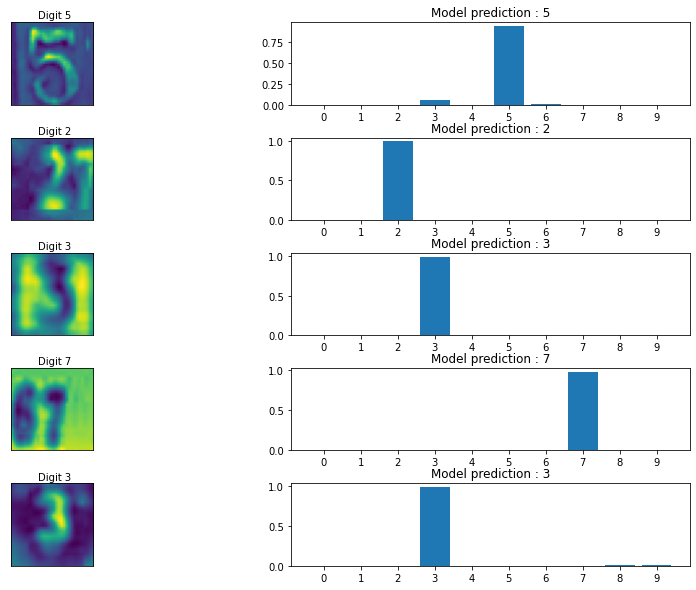

<Figure size 432x288 with 0 Axes>

In [42]:
index_random = np.random.choice(test_data_gray.shape[0],5)
random_test_data = test_data_gray_cnn[index_random, ...]
random_test_label = test_labels[index_random, ...]

cnn_predictions = cnn_model.predict(random_test_data)
fig,axes = plt.subplots(5,2, figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.1)

for i, (mpl_predictions, image, label) in enumerate(zip(cnn_predictions, random_test_data, random_test_label)):
  axes[i,0].imshow(np.squeeze(image))
  axes[i,0].get_xaxis().set_visible(False)
  axes[i,0].get_yaxis().set_visible(False)
  axes[i,0].text(10,-2, f'Digit {label}')
  axes[i,1].bar(np.arange(len(mpl_predictions)),mpl_predictions)
  axes[i,1].set_xticks(np.arange(len(mpl_predictions)))
  axes[i,1].set_title(f'Model prediction : {np.argmax(mpl_predictions)}')
plt.show()
plt.savefig('gif.png')